[LSTM] epoch 05 loss 0.37246
[LSTM] epoch 10 loss 0.17951
[LSTM] epoch 15 loss 0.08375
[LSTM] epoch 20 loss 0.03451
[LSTM] epoch 25 loss 0.01640
[LSTM] epoch 30 loss 0.01199
[Classifier] eval:
               precision    recall  f1-score   support

           0      0.951     1.000     0.975       365
           1      0.000     0.000     0.000        19

    accuracy                          0.951       384
   macro avg      0.475     0.500     0.487       384
weighted avg      0.903     0.951     0.926       384


Saved alerts to: ./artifacts/alerts.csv  (rows=1920)


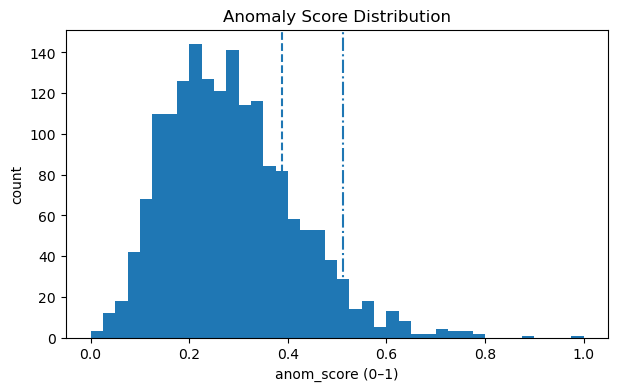

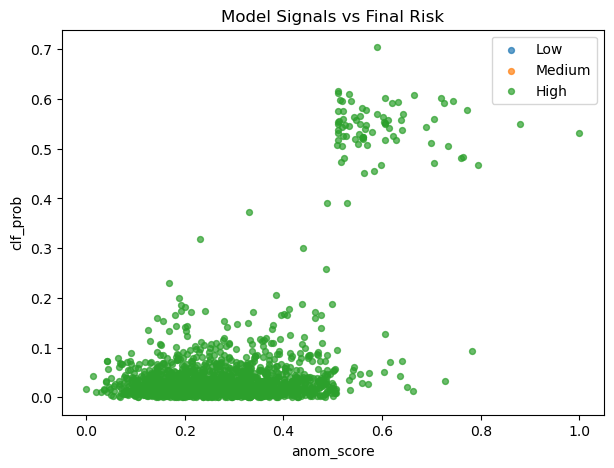

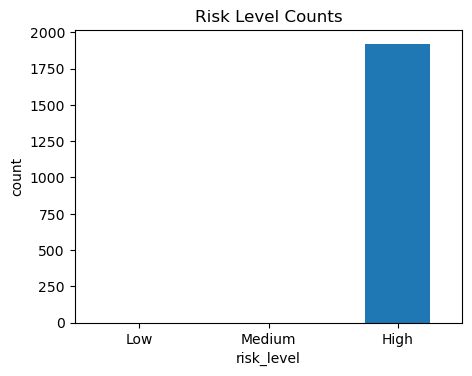

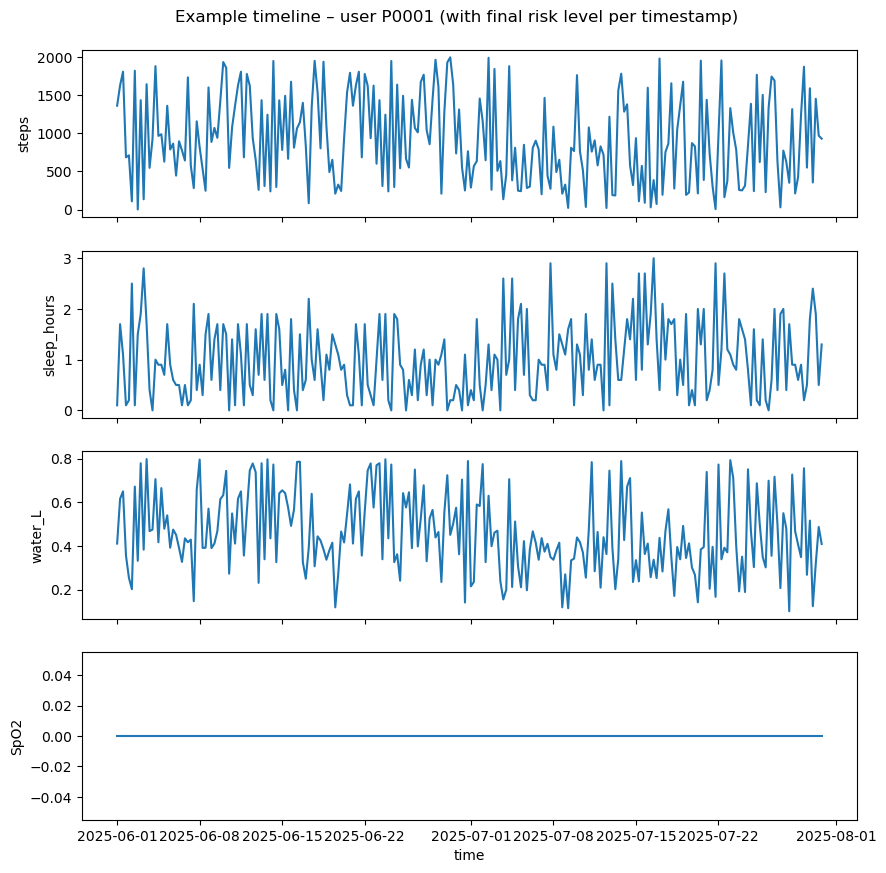

,user_id,timestamp,anom_score,clf_prob,risk_level,reason
0,P0001,2025-06-01 00:00:00+00:00,NaN,0.002222,High,SpO₂ 0% (<90); Very low activity (5 min)
1,P0001,2025-06-01 06:00:00+00:00,NaN,0.008778,High,SpO₂ 0% (<90); Low activity (16 min)
2,P0001,2025-06-01 12:00:00+00:00,NaN,0.000833,High,SpO₂ 0% (<90); Very low activity (6 min)
3,P0001,2025-06-01 18:00:00+00:00,NaN,0.001111,High,SpO₂ 0% (<90); Low activity (10 min)
4,P0001,2025-06-02 00:00:00+00:00,NaN,0.000000,High,SpO₂ 0% (<90); Very low activity (4 min)
5,P0001,2025-06-02 06:00:00+00:00,NaN,0.001111,High,SpO₂ 0% (<90); Very low activity (0 min); Meal...
6,P0001,2025-06-02 12:00:00+00:00,NaN,0.006500,High,SpO₂ 0% (<90); Very low activity (8 min)
7,P0001,2025-06-02 18:00:00+00:00,NaN,0.007405,High,SpO₂ 0% (<90); Very low activity (0 min)
8,P0001,2025-06-03 00:00:00+00:00,NaN,0.004944,High,SpO₂ 0% (<90); Low activity (19 min)
9,P0001,2025-06-03 06:00:00+00:00,NaN,0.032611,High,SpO₂ 0% (<90); Very low activity (0 min)


In [1]:
# =========================================================
# Guardian Alert System with Health Risk Detection – Behaviour + Vitals
# Outputs: user_id, timestamp, anom_score, clf_prob, risk_level, reason
# Visualizations included
# =========================================================

# --- Install once per fresh environment ---
try:
    import torch, pandas, sklearn, matplotlib
except Exception:
    import sys
    !{sys.executable} -m pip install --quiet torch scikit-learn pandas numpy joblib matplotlib

# --- Imports & config ---
import os, json, math, re, warnings, glob
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

warnings.filterwarnings("ignore")

# Optional PyTorch (for LSTM)
try:
    import torch
    from torch import nn
    TORCH_OK = True
except Exception:
    TORCH_OK = False
    torch = None
    nn = None

# --- Tunables ---
ENGINE = "lstm"    # "lstm" or "iforest" (falls back to iforest if torch unavailable)
CLF    = "rf"      # "rf" or "mlp"
SEQ_LEN       = 14
TEST_SIZE     = 0.2
RANDOM_STATE  = 42

# Canonical names used across pipeline
ID_COL = "user_id"
TS_COL = "timestamp"

# Behavioural features
BEHAV = ["steps","calorie_intake","sleep_hours","water_intake","bathroom_visits"]
# Vitals & context features
VITAL = ["heart_rate","spo2","temperature","bp_sys","bp_dia","meals_skipped","exercise_minutes"]
# Full feature list for models
FULL_FEATURES = BEHAV + VITAL

OUTDIR = os.path.join(".", "artifacts")
os.makedirs(OUTDIR, exist_ok=True)

# -------------------------
# Dataset discovery (same dir)
# -------------------------
def find_dataset_here() -> Tuple[str, str]:
    cands = []
    for ext in ("*.csv","*.xlsx","*.xls"):
        cands += glob.glob(os.path.join(".", "**", ext), recursive=True)
    if not cands:
        raise FileNotFoundError("No CSV/Excel found in current directory.")
    def score(p):
        n = os.path.basename(p).lower()
        s = 0
        if "new ai spreadsheet" in n: s += 5
        if "sheet1" in n: s += 2
        if "alert" in n or "alerts" in n: s += 2
        if n.endswith(".csv"): s += 1
        return -s
    cands.sort(key=score)
    chosen = cands[0]
    kind = "csv" if chosen.lower().endswith(".csv") else "excel"
    return chosen, kind

DATA_PATH, DATA_KIND = find_dataset_here()

# -------------------------
# Load & normalize columns
# -------------------------
_bp_re = re.compile(r"^\s*(\d+)\s*[/\-]\s*(\d+)\s*$")
def parse_bp(val):
    if pd.isna(val): return (np.nan, np.nan)
    if isinstance(val,(int,float)): return (float(val), np.nan)
    m = _bp_re.match(str(val))
    if m: return (float(m.group(1)), float(m.group(2)))
    return (np.nan, np.nan)

def _read_any(path: str, kind: str) -> pd.DataFrame:
    if kind == "csv":
        return pd.read_csv(path)
    else:
        try:
            return pd.read_excel(path, sheet_name="Sheet1")
        except Exception:
            return pd.read_excel(path)

def load_dataset(path: str, kind: str) -> pd.DataFrame:
    raw = _read_any(path, kind)
    raw.columns = [c.strip() for c in raw.columns]

    # Map your real headers -> canonical
    rename_map = {
        "patientId": ID_COL,
        "observationStart": TS_COL if "observationStart" in raw.columns else None,
        "observationEnd":   TS_COL if ("observationStart" not in raw.columns and "observationEnd" in raw.columns) else None,
        "stepsTaken":       "steps",
        "calorieIntake":    "calorie_intake",
        "sleepHours":       "sleep_hours",
        "waterIntakeMl":    "water_intake",  # convert mL -> L
        "bathroomVisits":   "bathroom_visits",
        "heartRate":        "heart_rate",
        "spo2":             "spo2",
        "temperature":      "temperature",   # assumed °C
        "bloodPressure":    "bloodPressure", # to be parsed
        "mealsSkipped":     "meals_skipped",
        "exerciseMinutes":  "exercise_minutes",
    }
    rename_map = {k:v for k,v in rename_map.items() if v is not None}

    # Basic expectation for behaviourals
    need_raw = ["patientId","stepsTaken","calorieIntake","sleepHours","waterIntakeMl","bathroomVisits"]
    miss = [c for c in need_raw if c not in raw.columns]
    if miss:
        raise ValueError(f"Dataset missing required behavioural columns: {miss}\nHave: {list(raw.columns)}")

    if ("observationStart" not in raw.columns) and ("observationEnd" not in raw.columns):
        raw["_seq"] = range(len(raw))
        raw["observationStart"] = pd.Timestamp("2025-01-01") + pd.to_timedelta(raw["_seq"], unit="D")
        raw.drop(columns=["_seq"], inplace=True)

    df = raw.rename(columns=rename_map)

    if ID_COL not in df.columns: df[ID_COL] = "user_1"
    if TS_COL not in df.columns: raise ValueError("No timestamp column found or derived.")

    # Parse time
    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce")
    if df[TS_COL].isna().any():
        bad = df.loc[df[TS_COL].isna(), [TS_COL]].head(3)
        raise ValueError(f"Unparseable timestamps:\n{bad}")

    # BP -> bp_sys/bp_dia
    if "bloodPressure" in df.columns:
        bp = df["bloodPressure"].apply(parse_bp)
        df["bp_sys"] = bp.map(lambda t: t[0])
        df["bp_dia"] = bp.map(lambda t: t[1])
        df.drop(columns=["bloodPressure"], inplace=True, errors="ignore")
    else:
        df["bp_sys"] = np.nan; df["bp_dia"] = np.nan

    # Units & numerics
    df["water_intake"] = pd.to_numeric(df["water_intake"], errors="coerce") / 1000.0
    for c in ["steps","calorie_intake","sleep_hours","bathroom_visits",
              "heart_rate","spo2","temperature","bp_sys","bp_dia","meals_skipped","exercise_minutes"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Sort & small gaps
    df[ID_COL] = df[ID_COL].fillna("user_1").astype(str)
    df = df.sort_values([ID_COL, TS_COL]).reset_index(drop=True)

    for c in FULL_FEATURES:
        df[c] = df.groupby(ID_COL)[c].transform(lambda s: s.interpolate(limit_direction="both"))
        df[c] = df[c].fillna(method="bfill").fillna(method="ffill")
        df[c] = df[c].fillna(0)

    keep = [ID_COL, TS_COL] + FULL_FEATURES
    miss2 = [c for c in keep if c not in df.columns]
    if miss2: raise ValueError(f"Missing final columns: {miss2}")
    return df[keep].copy()

df = load_dataset(DATA_PATH, DATA_KIND)

# -------------------------
# Seq builders & utils
# -------------------------
def make_sequences(df_user: pd.DataFrame, seq_len: int, feature_cols: List[str], ts_col: str):
    X, ends = [], []
    vals = df_user[feature_cols].values.astype(float)
    for i in range(len(vals) - seq_len + 1):
        X.append(vals[i:i+seq_len]); ends.append(df_user.iloc[i+seq_len-1][ts_col])
    return np.array(X), np.array(ends)

def stack_all_users(df: pd.DataFrame, seq_len: int, feature_cols: List[str], id_col: str, ts_col: str):
    X_all, ends_all, owners = [], [], []
    for uid, g in df.groupby(id_col):
        X, ends = make_sequences(g, seq_len, feature_cols, ts_col)
        if len(X)==0: continue
        X_all.append(X); ends_all.append(ends); owners += [uid]*len(X)
    if not X_all:
        raise ValueError("No sequences created. Reduce SEQ_LEN or check cadence.")
    return np.vstack(X_all), np.concatenate(ends_all), np.array(owners)

def minmax_scale_with_bounds(x):
    lo, hi = float(np.min(x)), float(np.max(x))
    if math.isclose(hi, lo): 
        return np.zeros_like(x), lo, hi
    return (x - lo) / (hi - lo), lo, hi

# -------------------------
# LSTM Autoencoder
# -------------------------
class LSTMAE(nn.Module):
    def __init__(self, n_features, hidden=32, latent=16):
        super().__init__()
        self.encoder = nn.LSTM(n_features, hidden, batch_first=True)
        self.enc_linear = nn.Linear(hidden, latent)
        self.decoder = nn.LSTM(n_features, hidden, batch_first=True)
        self.dec_linear = nn.Linear(hidden, n_features)
    def forward(self, x):
        enc_out,_ = self.encoder(x)
        _ = self.enc_linear(enc_out)
        dec_out,_ = self.decoder(x)
        return self.dec_linear(dec_out)

def train_lstm_autoencoder(X, n_epochs=30, lr=1e-3, batch=128, device="cpu"):
    model = LSTMAE(X.shape[-1]); model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
    dl = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=True)
    for epoch in range(1, n_epochs+1):
        losses = []
        for (xb,) in dl:
            xb = xb.to(device); pred = model(xb); loss = loss_fn(pred, xb)
            opt.zero_grad(); loss.backward(); opt.step(); losses.append(loss.item())
        if epoch % 5 == 0:
            print(f"[LSTM] epoch {epoch:02d} loss {np.mean(losses):.5f}")
    return model

def recon_error(model, X, device="cpu"):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        out = model(X_t).cpu().numpy()
    return ((out - X)**2).mean(axis=(1,2))

# -------------------------
# Classifier features
# -------------------------
def add_feats(df: pd.DataFrame, id_col: str, cols: List[str], ts_col: str) -> pd.DataFrame:
    g = df.sort_values([id_col, ts_col]).copy()
    for f in cols:
        g[f+"_delta"]  = g.groupby(id_col)[f].transform(lambda s: s.diff())
        g[f+"_rmean7"] = g.groupby(id_col)[f].transform(lambda s: s.rolling(7, min_periods=1).mean())
        rstd           = g.groupby(id_col)[f].transform(lambda s: s.rolling(7, min_periods=2).std())
        g[f+"_rz7"]    = (g[f] - g[f+"_rmean7"]) / rstd.replace(0, np.nan)
    g = g.replace([np.inf,-np.inf], np.nan).fillna(0)
    return g

def build_classifier(name: str):
    if name == "rf":
        return RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=4,
                                      random_state=RANDOM_STATE, n_jobs=-1)
    elif name == "mlp":
        return MLPClassifier(hidden_layer_sizes=(64,32), activation="relu", max_iter=300,
                             random_state=RANDOM_STATE)
    else:
        raise ValueError("CLF must be 'rf' or 'mlp'")

# -------------------------
# Clinically-anchored vital risk
# -------------------------
def vital_risk_and_reasons(row):
    """
    Clinically grounded thresholds:
      SpO2: Low >=95, Med 90–94, High <90
      Temp °C: Low <38.0, Med 38.0–39.3, High >=39.4
      BP: Low <130/<80; Med 130–139 or 80–89; High >=140 or >=90 (crisis >=180/120)
      Exercise (per day): Low >=20 min, Med 10–19, High <10
      Meals skipped (per day): Low 0–1, Med 2, High >=3
    """
    reasons_med = []
    reasons_high = []

    s = row.get("spo2", np.nan)
    if pd.notna(s):
        if s < 90: reasons_high.append(f"SpO₂ {s:.0f}% (<90)")
        elif s < 95: reasons_med.append(f"SpO₂ {s:.0f}% (90–94)")

    t = row.get("temperature", np.nan)
    if pd.notna(t):
        if t >= 39.4: reasons_high.append(f"High fever {t:.1f}°C (≥39.4)")
        elif t >= 38.0: reasons_med.append(f"Fever {t:.1f}°C (≥38.0)")

    sys = row.get("bp_sys", np.nan); dia = row.get("bp_dia", np.nan)
    if pd.notna(sys) and pd.notna(dia):
        if sys >= 180 or dia >= 120:
            reasons_high.append(f"Hypertensive crisis {int(sys)}/{int(dia)}")
        elif sys >= 140 or dia >= 90:
            reasons_high.append(f"Stage 2 HTN {int(sys)}/{int(dia)}")
        elif (130 <= sys <= 139) or (80 <= dia <= 89):
            reasons_med.append(f"Stage 1 HTN {int(sys)}/{int(dia)}")

    ex = row.get("exercise_minutes", np.nan)
    if pd.notna(ex):
        if ex < 10: reasons_med.append(f"Very low activity ({int(ex)} min)")
        elif ex < 20: reasons_med.append(f"Low activity ({int(ex)} min)")

    ms = row.get("meals_skipped", np.nan)
    if pd.notna(ms):
        if ms >= 3: reasons_high.append(f"Meals skipped: {int(ms)}")
        elif ms == 2: reasons_med.append("Meals skipped: 2")

    if reasons_high: return "High", reasons_high + reasons_med
    if reasons_med:  return "Medium", reasons_med
    return "Low", []

def combine_risk(model_risk, vital_risk):
    order = {"Low":0,"Medium":1,"High":2}
    return model_risk if order[model_risk] >= order[vital_risk] else vital_risk

# -------------------------
# Pipeline
# -------------------------

# 1) Scale features for anomaly engine
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[FULL_FEATURES] = scaler.fit_transform(df_scaled[FULL_FEATURES])
joblib.dump(scaler, os.path.join(OUTDIR, "scaler.pkl"))

# 2) Train anomaly engine on FULL_FEATURES
engine_used = ENGINE if TORCH_OK or ENGINE=="iforest" else "iforest"

if engine_used == "lstm":
    X_seq, ends, owners = stack_all_users(df_scaled, SEQ_LEN, FULL_FEATURES, ID_COL, TS_COL)
    device = "cuda" if (TORCH_OK and torch.cuda.is_available()) else "cpu"
    model = train_lstm_autoencoder(X_seq, n_epochs=30, lr=1e-3, batch=128, device=device)
    torch.save(model.state_dict(), os.path.join(OUTDIR, "lstm.pt"))
    recon_errs = recon_error(model, X_seq, device=device)
    seq_scores = pd.DataFrame({ID_COL: owners, TS_COL: ends, "recon_error": recon_errs})
else:
    iforest = IsolationForest(n_estimators=300, contamination=0.05, random_state=RANDOM_STATE)
    iforest.fit(df_scaled[FULL_FEATURES])
    recon_errs = -iforest.score_samples(df_scaled[FULL_FEATURES])  # higher => more anomalous (error-like)
    seq_scores = df_scaled[[ID_COL, TS_COL]].copy()
    seq_scores["recon_error"] = recon_errs
    joblib.dump(iforest, os.path.join(OUTDIR, "iforest.pkl"))

# Normalize to anom_score 0..1 (and keep bounds for plotting)
anom_score, err_min, err_max = minmax_scale_with_bounds(seq_scores["recon_error"].values)
seq_scores["anom_score"] = anom_score

# Calibrate thresholds by distribution of recon_error (not anom_score)
err_p80 = float(np.percentile(seq_scores["recon_error"], 80))
err_p95 = float(np.percentile(seq_scores["recon_error"], 95))
with open(os.path.join(OUTDIR, "thresholds.json"), "w") as f:
    json.dump({"err_min": float(err_min), "err_max": float(err_max),
               "err_p80": err_p80, "err_p95": err_p95}, f, indent=2)

# 3) Behavioural + vital classifier (weak labels from recon_error 95th percentile)
feats_df = add_feats(df.copy(), ID_COL, FULL_FEATURES, TS_COL)
clf_cols = []
for f in FULL_FEATURES:
    clf_cols += [f, f+"_delta", f+"_rmean7", f+"_rz7"]

tmp = feats_df[[ID_COL, TS_COL]].merge(seq_scores[[ID_COL, TS_COL, "recon_error"]],
                                       on=[ID_COL, TS_COL], how="left")
cutoff = np.percentile(tmp["recon_error"].fillna(tmp["recon_error"].median()), 95)
labels = (tmp["recon_error"] >= cutoff).astype(int)
feats_df["label"] = labels

X = feats_df[clf_cols].fillna(0).values
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,
    stratify=y if (y.sum()>0 and y.sum()<len(y)) else None
)
clf = build_classifier(CLF)
clf.fit(X_train, y_train)
if y_test.sum()>0 and y_test.sum()<len(y_test):
    print("[Classifier] eval:\n", classification_report(y_test, clf.predict(X_test), digits=3))
joblib.dump(clf, os.path.join(OUTDIR, "clf.pkl"))

# 4) Build final alerts (keep anom_score & clf_prob; remove model_risk/vital_risk from output)
out = feats_df[[ID_COL, TS_COL]].merge(
    seq_scores[[ID_COL, TS_COL, "recon_error", "anom_score"]],
    on=[ID_COL, TS_COL], how="left"
).sort_values([ID_COL, TS_COL])

# Classifier probability
if hasattr(clf, "predict_proba"):
    clf_prob = clf.predict_proba(feats_df[clf_cols])[:,1]
else:
    rawp = clf.decision_function(feats_df[clf_cols])
    # scale to 0..1 for readability
    clf_prob = (rawp - rawp.min()) / (rawp.max() - rawp.min() + 1e-12)
out["clf_prob"] = clf_prob

# Attach needed vitals for rule check
attach_cols = ["spo2","temperature","bp_sys","bp_dia","exercise_minutes","meals_skipped"]
out = out.merge(df[[ID_COL, TS_COL]+attach_cols], on=[ID_COL, TS_COL], how="left")

# Model risk via calibrated thresholds
def model_risk_from_err_prob(recon_err, prob, p80, p95):
    if (recon_err >= p95) or (prob >= 0.85): return "High"
    if (recon_err >= p80) or (prob >= 0.65): return "Medium"
    return "Low"

# Compute final risk and reasons (only one risk_level column)
final_levels = []
reasons = []
for _, row in out.iterrows():
    m_risk = model_risk_from_err_prob(row["recon_error"], row["clf_prob"], err_p80, err_p95)
    v_risk, v_flags = vital_risk_and_reasons(row)
    final = combine_risk(m_risk, v_risk)
    final_levels.append(final)

    # Reasoning: include all triggers for Medium/High; blank for Low
    rs = []
    if final in ("Medium","High"):
        # Model reasons
        if m_risk == "High":
            if row["recon_error"] >= err_p95: rs.append("Strong sequence anomaly (≥95th percentile)")
            if row["clf_prob"] >= 0.85: rs.append("Classifier: strong behavioural anomaly (≥0.85)")
        elif m_risk == "Medium":
            if row["recon_error"] >= err_p80: rs.append("Moderate sequence anomaly (≥80th percentile)")
            if 0.65 <= row["clf_prob"] < 0.85: rs.append("Classifier: possible behavioural anomaly (≥0.65)")
        # Vital reasons (direction-aware flags)
        rs.extend(v_flags)
    else:
        # Keep blank for Low as requested emphasis is on Med/High explanations
        pass

    reasons.append("; ".join(rs))

out["risk_level"] = final_levels
out["reason"] = reasons

# Save ONLY requested columns
alerts = out[[ID_COL, TS_COL, "anom_score", "clf_prob", "risk_level", "reason"]].copy()
alerts_path = os.path.join(OUTDIR, "alerts.csv")
alerts.to_csv(alerts_path, index=False)

print(f"\nSaved alerts to: {alerts_path}  (rows={len(alerts)})")

# =========================
# Visualizations
# =========================

# 1) Anomaly score distribution (with p80/p95 markers mapped into 0..1)
plt.figure(figsize=(7,4))
plt.hist(alerts["anom_score"].dropna(), bins=40)
# map recon_error thresholds into anom_score scale for reference
def norm_err_to_anom(e, lo, hi):
    return 0.0 if math.isclose(hi, lo) else (e - lo) / (hi - lo)
anom_p80 = norm_err_to_anom(err_p80, err_min, err_max)
anom_p95 = norm_err_to_anom(err_p95, err_min, err_max)
plt.axvline(anom_p80, linestyle="--", linewidth=1.5)
plt.axvline(anom_p95, linestyle="-.", linewidth=1.5)
plt.title("Anomaly Score Distribution")
plt.xlabel("anom_score (0–1)")
plt.ylabel("count")
plt.show()

# 2) Scatter: anom_score vs clf_prob colored by final risk_level
plt.figure(figsize=(7,5))
for lvl in ["Low","Medium","High"]:
    sel = alerts[alerts["risk_level"]==lvl]
    plt.scatter(sel["anom_score"], sel["clf_prob"], label=lvl, s=18, alpha=0.7)
plt.legend()
plt.xlabel("anom_score")
plt.ylabel("clf_prob")
plt.title("Model Signals vs Final Risk")
plt.show()

# 3) Risk counts
plt.figure(figsize=(5,3.8))
alerts["risk_level"].value_counts().reindex(["Low","Medium","High"]).plot(kind="bar")
plt.title("Risk Level Counts")
plt.xlabel("risk_level")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()

# 4) Example timeline for a representative patient (highest max risk)
top_user = (
    alerts.assign(rank=alerts["risk_level"].map({"Low":0,"Medium":1,"High":2}))
          .sort_values(["rank", TS_COL], ascending=[False, True])[ID_COL]
          .iloc[0]
)
user_df = df[df[ID_COL]==top_user].merge(alerts[[ID_COL, TS_COL, "risk_level"]], on=[ID_COL, TS_COL], how="left")
fig, axes = plt.subplots(4, 1, figsize=(10,10), sharex=True)
axes[0].plot(user_df[TS_COL], user_df["steps"]); axes[0].set_ylabel("steps")
axes[1].plot(user_df[TS_COL], user_df["sleep_hours"]); axes[1].set_ylabel("sleep_hours")
axes[2].plot(user_df[TS_COL], user_df["water_intake"]); axes[2].set_ylabel("water_L")
axes[3].plot(user_df[TS_COL], user_df["spo2"]); axes[3].set_ylabel("SpO2"); axes[3].set_xlabel("time")
fig.suptitle(f"Example timeline – user {top_user} (with final risk level per timestamp)", y=0.92)
plt.show()

alerts.head(10)
